Imports and Constants

In [1]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

sys.path.append(r"E:\Dropbox (Weizmann Institute)\Lab\Code\Python Scripts Jupyter")
from entities_v2 import GCaMPData, LimbData, Frame, Clip, Experiment  # noqa: F401

USER CONFIG (edit here only)

In [2]:
CFG = {
    "data_folder": r"Z:\UriMons\Fiber Photometry\GCaMP\adBNST_eEPA_GCaMP8s\Processed_Data\All_pikles",
    "frame_rate": 30,

    # preprocessing
    "smooth_threshold": 45,

    # bout rules
    "min_len_s": 2.5,
    "max_len_s": 300,
    "pre_time_s": 6,

    # baseline window for "local" correction
    # You used pre+bout: [-PRE, MIN_LEN]. Keeping that default.
    "baseline_window": "pre_plus_bout",  # options: "pre_only" or "pre_plus_bout"
    "baseline_scale": 0.9,               # your original "avg - baseline*0.9"

    # stats
    "bin_s": 0.333,
    "alpha_fdr": 0.1,

    # plotting
    "figsize": (12, 6),
    "show_individuals": True,
    "colors": {
        "WT": "blue",
        "KO": "red",
        "Female": "#A60B59",
        "Male": "#0900B7",
    },
    # baseline/centering for plotting ONLY (does not affect stats)
    "plot_centering": {
        "enabled": True,
        "target_groups": ["WT"],     # ["WT"] to shift WT only; or ["WT","KO"] to shift both independently
        "window": "pre",             # currently only "pre" implemented (A)
        "shift_fraction": 1.0,       # 1.0 = fully center to 0, 0.5 = half shift, 0 = no shift
        "target_level": 0.1,         # where you want the pre-mean to land (0.0 by default)
    },
}

Loading

In [3]:
def load_experiments(data_folder):
    experiments = []
    for file in os.listdir(data_folder):
        if file.endswith(".pkl"):
            path = os.path.join(data_folder, file)
            with open(path, "rb") as f:
                exp = pickle.load(f)
            experiments.append(exp)
            print(f"Loaded: {file}")
    print(f"Total .pkl files loaded: {len(experiments)}")
    return experiments

Grouping helpers

In [4]:
def get_sapap_genotype(geno_str):
    geno_str = str(geno_str)
    if "Sapap(" in geno_str:
        start = geno_str.find("Sapap(") + len("Sapap(")
        end = geno_str.find(")", start)
        return geno_str[start:end]
    return None

def group_by_genotype(experiments):
    groups = {"WT": [], "KO": []}
    for exp in experiments:
        geno = get_sapap_genotype(getattr(exp, "Genotype", ""))
        if geno in groups:
            groups[geno].append(exp)
        else:
            print(f"Warning: unknown genotype for {getattr(exp, 'Mouse_id', 'UNK')}: {getattr(exp,'Genotype',None)}")
    print(f"WT mice: {len(groups['WT'])}, KO mice: {len(groups['KO'])}")
    return groups

def group_by_sex(experiments):
    groups = {"Female": [], "Male": []}
    for exp in experiments:
        s = str(getattr(exp, "Sex", "")).strip().lower()
        if s in {"f", "female", "♀"}:
            groups["Female"].append(exp)
        elif s in {"m", "male", "♂"}:
            groups["Male"].append(exp)
        else:
            print(f"Warning: unknown/blank sex for {getattr(exp,'Mouse_id','UNK')}: {getattr(exp,'Sex',None)}")
    print(f"Female mice: {len(groups['Female'])}, Male mice: {len(groups['Male'])}")
    return groups

def apply_plot_centering(group_label, common_t, mouse_data, group_avg, cfg):
    """
    Plot-only centering (does not affect stats).
    Uses mean of pre window [-pre_time, 0] (Option A).
    You can apply full/partial shifting via shift_fraction.
    """
    pcfg = cfg.get("plot_centering", {})
    if not pcfg.get("enabled", False):
        return mouse_data, group_avg, 0.0

    if group_label not in set(pcfg.get("target_groups", [])):
        return mouse_data, group_avg, 0.0

    if group_avg is None:
        return mouse_data, group_avg, 0.0

    pre_t = cfg["pre_time_s"]
    mask = (common_t >= -pre_t) & (common_t <= 0)

    pre_mean = float(np.mean(group_avg[mask]))
    target = float(pcfg.get("target_level", 0.0))
    frac = float(pcfg.get("shift_fraction", 1.0))

    # shift to move pre_mean toward target by a fraction
    # full shift would be (target - pre_mean)
    shift = frac * (target - pre_mean)

    # apply shift to group avg + each mouse trace
    new_group_avg = group_avg + shift
    new_mouse_data = {m: (tr + shift) for m, tr in mouse_data.items() if tr is not None}

    return new_mouse_data, new_group_avg, shift


Core pipeline steps

In [5]:
def detect_medium_bouts(exps, min_sec, max_sec, frame_rate):
    min_f, max_f = int(min_sec * frame_rate), int(max_sec * frame_rate)
    bouts = {}
    total = 0
    for exp in exps:
        ann = getattr(exp, "Grooming_annotations", None) or []
        valid = [(s, e) for s, e in ann if min_f <= (e - s) <= max_f]
        bouts[exp.Mouse_id] = valid
        total += len(valid)
    return total, bouts

def filter_by_pre_activity(exps, bouts_dict, pre_sec, frame_rate):
    pre_f = int(pre_sec * frame_rate)
    filt_bouts = {}
    filt_traces = {}
    for exp in exps:
        ann = getattr(exp, "Grooming_annotations", None) or []
        valid = bouts_dict.get(exp.Mouse_id, [])
        good, traces = [], []
        for s, e in valid:
            has_pre = any((oe > s - pre_f) and (oe <= s) for os, oe in ann if (os, oe) != (s, e))
            if not has_pre:
                good.append((s, e))
                start = max(0, s - pre_f)
                trace, t = exp.get_gcamp_data_Z_score(start, e)
                traces.append((trace, t))
        filt_bouts[exp.Mouse_id] = good
        filt_traces[exp.Mouse_id] = traces
    return filt_bouts, filt_traces

def align_traces(traces_dict, bouts_dict, frame_rate):
    aligned = {}
    for m, traces in traces_dict.items():
        aligned[m] = []
        for (trace, t), (s, e) in zip(traces, bouts_dict.get(m, [])):
            aligned[m].append((trace, t - s / frame_rate))
    return aligned

def compute_common_t(pre_time, min_len, frame_rate):
    n = int((pre_time + min_len) * frame_rate)
    return np.linspace(-pre_time, min_len, n)

def _baseline_mask(common_t, pre_time, min_len, mode):
    if mode == "pre_only":
        return (common_t >= -pre_time) & (common_t <= 0)
    # default: pre_plus_bout
    return (common_t >= -pre_time) & (common_t <= min_len)

def compute_local_average(aligned, common_t, pre_time, min_len, baseline_mode, baseline_scale):
    """Per-mouse mean across bouts, subtract baseline (scaled), return per-mouse corrected + group avg/sem."""
    mask = _baseline_mask(common_t, pre_time, min_len, baseline_mode)

    local = {}
    for m, trs in aligned.items():
        if not trs:
            continue
        its = [np.interp(common_t, t, tr) for (tr, t) in trs if tr is not None and t is not None and len(tr) and len(t)]
        if not its:
            continue
        arr = np.vstack(its)
        avg = arr.mean(axis=0)
        baseline = avg[mask].mean()
        local[m] = avg - baseline * baseline_scale

    if not local:
        return {}, None, None

    mat = np.vstack(list(local.values()))
    grp_avg = mat.mean(axis=0)
    grp_sem = mat.std(axis=0, ddof=1) / np.sqrt(mat.shape[0])
    return local, grp_avg, grp_sem

def compute_local_median(aligned, common_t, pre_time, min_len, baseline_mode):
    """Per-mouse median across bouts, subtract baseline median, return per-mouse corrected + group median/sem."""
    mask = _baseline_mask(common_t, pre_time, min_len, baseline_mode)

    local = {}
    for m, trs in aligned.items():
        if not trs:
            continue
        its = [np.interp(common_t, t, tr) for (tr, t) in trs if tr is not None and t is not None and len(tr) and len(t)]
        if not its:
            continue
        arr = np.vstack(its)
        med = np.median(arr, axis=0)
        baseline = np.median(med[mask])
        local[m] = med - baseline

    if not local:
        return {}, None, None

    mat = np.vstack(list(local.values()))
    grp_med = np.median(mat, axis=0)
    grp_sem = mat.std(axis=0, ddof=1) / np.sqrt(mat.shape[0])
    return local, grp_med, grp_sem

def recenter_trace_to_baseline(trace, common_t, pre_time, baseline_mode, min_len):
    """Subtract baseline (mean over baseline window) from a 1D trace."""
    if trace is None:
        return None
    mask = _baseline_mask(common_t, pre_time, min_len, baseline_mode)
    baseline = np.mean(trace[mask])
    return trace - baseline


Stats helpers

In [6]:
def binned_group_test(mat_a, mat_b, bin_size, method="ttest"):
    """Return p-values and bin indices. mat_* shape: (n_mice, n_timepoints)."""
    n_bins = min(mat_a.shape[1], mat_b.shape[1]) // bin_size
    p_vals = []
    bin_indices = []
    for i in range(n_bins):
        start = i * bin_size
        end = start + bin_size
        a = mat_a[:, start:end].mean(axis=1)
        b = mat_b[:, start:end].mean(axis=1)
        _, p = ttest_ind(a, b, equal_var=False)
        p_vals.append(p)
        bin_indices.append((start, end))
    return np.array(p_vals), bin_indices

def fdr(p_vals, method="fdr_bh"):
    if len(p_vals) == 0:
        return np.array([])
    _, p_corr, _, _ = multipletests(p_vals, method=method)
    return p_corr

Plotting

In [7]:
def plot_traces(common_t, mouse_data, group_avg, group_sem, title, color, figsize=(12,6), show_ind=True, ylabel="Z-score"):
    plt.figure(figsize=figsize)

    has_individuals = bool(mouse_data) and any(tr is not None for tr in mouse_data.values())
    has_group = (group_avg is not None) and (group_sem is not None)

    if show_ind and has_individuals:
        for _, tr in mouse_data.items():
            if tr is None:
                continue
            plt.plot(common_t, tr, color="gray", alpha=0.5)

    if has_group:
        plt.plot(common_t, group_avg, color=color, linewidth=2, label=title)
        plt.fill_between(common_t, group_avg-group_sem, group_avg+group_sem, color=color, alpha=0.3)
    else:
        if not has_individuals:
            print(f"Skipping plot '{title}' (no data).")
            plt.close()
            return
        print(f"Plot '{title}': group_avg/sem missing, showing only individuals.")

    plt.axvline(0, linestyle="--", color="k")
    plt.xlabel("Time (s)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_combined(common_t, series_dict, figsize=(12,6), ylabel="Z-score", title=None):
    """
    series_dict: {label: (avg, sem, color)}
    plots whatever exists; skips missing.
    """
    plt.figure(figsize=figsize)
    plotted = False
    for label, (avg, sem, color) in series_dict.items():
        if avg is None or sem is None:
            continue
        plt.plot(common_t, avg, linewidth=2, label=label, color=color)
        plt.fill_between(common_t, avg-sem, avg+sem, alpha=0.3, color=color)
        plotted = True

    if not plotted:
        print("Skipping combined plot (no groups to plot).")
        plt.close()
        return

    plt.axvline(0, linestyle="--", color="k")
    plt.axhline(0, linestyle="--", color="k")
    plt.xlabel("Time (s)")
    plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

Unified analysis runner

In [ ]:
def run_pipeline_for_groups(groups, cfg, mode="avg"):
    """
    groups: dict label -> list[Experiment]
    mode: "avg" or "median"
    returns results dict with computed traces + optional stats
    """
    fr = cfg["frame_rate"]
    min_len = cfg["min_len_s"]
    max_len = cfg["max_len_s"]
    pre_t = cfg["pre_time_s"]
    common_t = compute_common_t(pre_t, min_len, fr)

    baseline_mode = "pre_plus_bout" if cfg["baseline_window"] == "pre_plus_bout" else "pre_only"

    results = {
        "common_t": common_t,
        "per_group": {},   # label -> dict of computed stuff
        "stats": {},       # (A,B) -> dict
        "cfg_snapshot": cfg,
        "mode": mode,
    }

    # Compute per group
    for label, exps in groups.items():
        total_bouts, raw_bouts = detect_medium_bouts(exps, min_len, max_len, fr)
        fb, ft = filter_by_pre_activity(exps, raw_bouts, pre_t, fr)
        aligned = align_traces(ft, fb, fr)

        if mode == "avg":
            local, gavg, gsem = compute_local_average(
                aligned, common_t, pre_t, min_len, baseline_mode, cfg["baseline_scale"]
            )
        else:
            local, gavg, gsem = compute_local_median(
                aligned, common_t, pre_t, min_len, baseline_mode
            )

        # --- NEW: Recenter each GROUP separately using its own group-average baseline ---
        if gavg is not None:
            gavg = recenter_trace_to_baseline(gavg, common_t, pre_t, baseline_mode, min_len)
            # gsem does not change when you subtract a constant baseline

        n_mice = len(local)
        n_bouts = sum(len(v) for v in aligned.values()) if aligned else 0

        results["per_group"][label] = {
            "exps": exps,
            "total_bouts_raw": total_bouts,
            "aligned": aligned,
            "local": local,            # dict mouse -> trace
            "group_avg": gavg,         # avg or median
            "group_sem": gsem,
            "n_mice": n_mice,
            "n_bouts": n_bouts,
        }


    # Pairwise stats (only if exactly two groups present and both non-empty)
    labels = list(groups.keys())
    if len(labels) == 2:
        A, B = labels[0], labels[1]

        # --- SAFETY: if a group wasn't added (e.g., no valid data), skip stats ---
        if (A not in results["per_group"]) or (B not in results["per_group"]):
            results["stats"][(A, B)] = None
            return results

        da = results["per_group"][A]
        db = results["per_group"][B]

        if da["group_avg"] is not None and db["group_avg"] is not None and len(da["local"]) and len(db["local"]):
            bin_size = int(cfg["bin_s"] * fr)
            mat_a = np.vstack(list(da["local"].values()))
            mat_b = np.vstack(list(db["local"].values()))
            p_vals, bin_indices = binned_group_test(mat_a, mat_b, bin_size, method="ttest")
            p_corr = fdr(p_vals)

            results["stats"][(A, B)] = {
                "bin_size": bin_size,
                "bin_indices": bin_indices,
                "p_vals": p_vals,
                "p_corr": p_corr,
                "sig_mask": (p_corr < cfg["alpha_fdr"]) if len(p_corr) else np.array([]),
            }
        else:
            results["stats"][(A, B)] = None

    return results

MAIN: compute everything first, then plot at end

Loaded: M329_eEPA_R_adBNST.pkl
Loaded: M344_eEPA_R_adBNST.pkl
Loaded: M352_eEPA_R_adBNST.pkl
Loaded: M354_eEPA_R_adBNST.pkl
Loaded: M365_eEPA_R_adBNST.pkl
Loaded: M406_eEPA_R_adBNST.pkl
Loaded: M407_eEPA_R_adBNST.pkl
Loaded: M416_eEPA_R_adBNST.pkl
Loaded: M420_eEPA_R_adBNST.pkl
Loaded: M501_eEPA_R_adBNST.pkl
Loaded: M508_eEPA_R_adBNST.pkl
Loaded: M511_eEPA_R_adBNST.pkl
Loaded: M546_eEPA_R_adBNST.pkl
Loaded: M561_eEPA_R_adBNST.pkl
Total .pkl files loaded: 14
WT mice: 7, KO mice: 7
Female mice: 8, Male mice: 6
WT: plot centering shift applied = 0.080


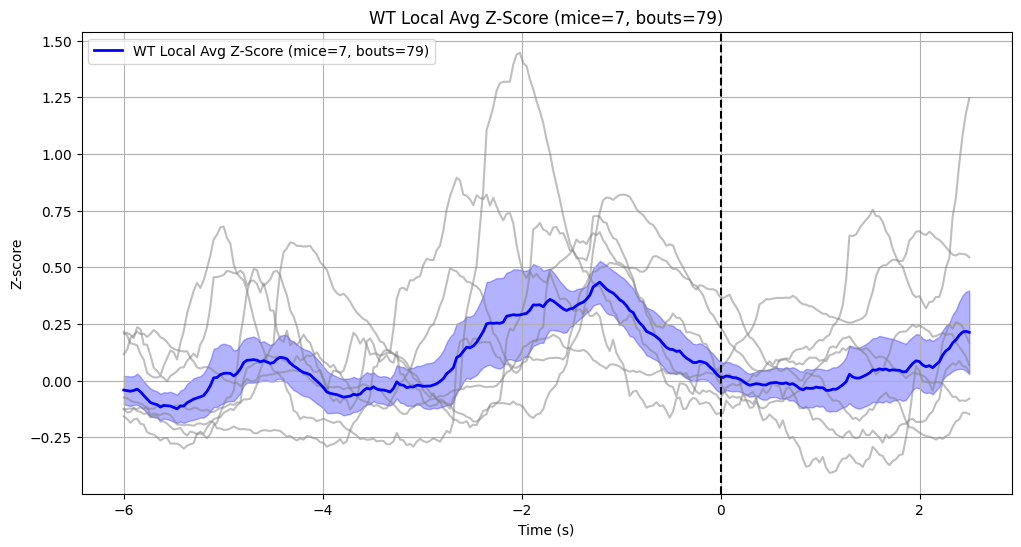

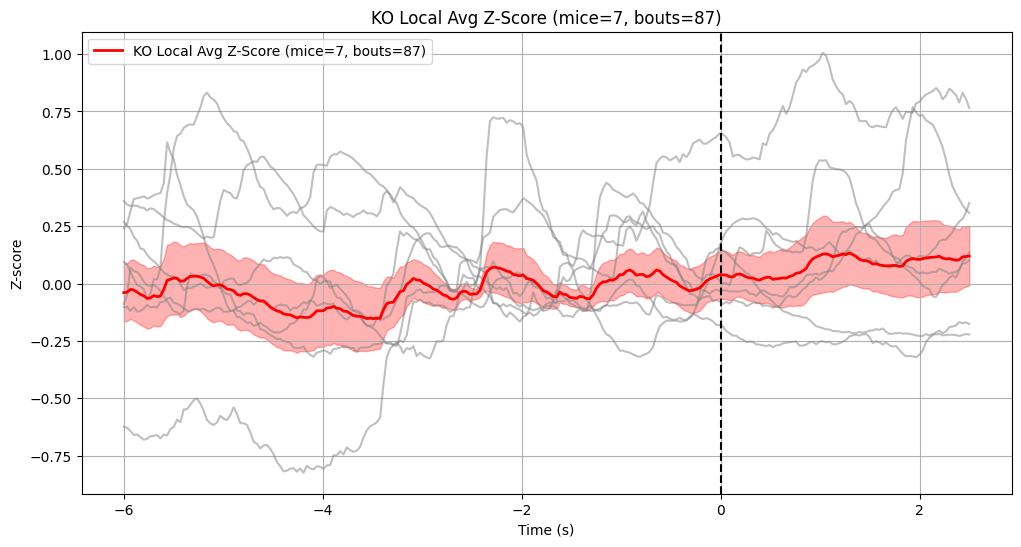

WT combined plot shift applied = 0.080


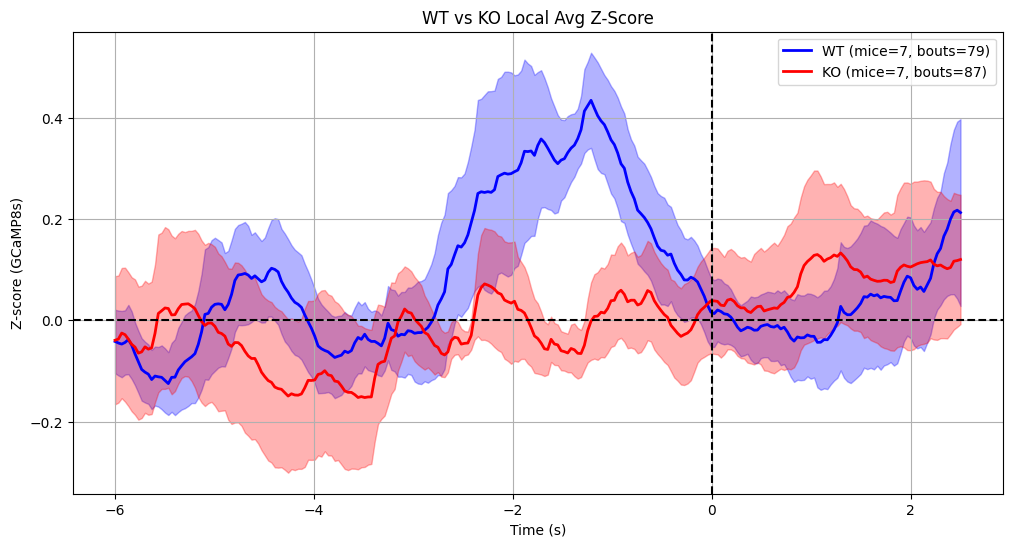


WT vs KO (Average) bin stats
Bin	TimeRange	P_uncorrected	P_corrected	Sig(FDR)
0	-6.00--5.73s	0.492	0.856	False
1	-5.70--5.43s	0.243	0.856	False
2	-5.40--5.13s	0.316	0.856	False
3	-5.10--4.83s	0.844	0.904	False
4	-4.80--4.53s	0.737	0.904	False
5	-4.49--4.23s	0.519	0.856	False
6	-4.19--3.93s	0.872	0.904	False
7	-3.89--3.62s	0.856	0.904	False
8	-3.59--3.32s	0.992	0.992	False
9	-3.29--3.02s	0.439	0.856	False
10	-2.99--2.72s	0.64	0.896	False
11	-2.69--2.42s	0.551	0.856	False
12	-2.39--2.12s	0.614	0.896	False
13	-2.08--1.82s	0.376	0.856	False
14	-1.78--1.52s	0.0534	0.747	False
15	-1.48--1.21s	0.00193	0.054	True
16	-1.18--0.91s	0.0918	0.856	False
17	-0.88--0.61s	0.501	0.856	False
18	-0.58--0.31s	0.802	0.904	False
19	-0.28--0.01s	0.783	0.904	False
20	0.02-0.29s	0.318	0.856	False
21	0.32-0.59s	0.34	0.856	False
22	0.63-0.89s	0.328	0.856	False
23	0.93-1.19s	0.202	0.856	False
24	1.23-1.50s	0.305	0.856	False
25	1.53-1.80s	0.521	0.856	False
26	1.83-2.10s	0.522	0.856	False
27	2.13-2.40s	0.7	0.904	Fa

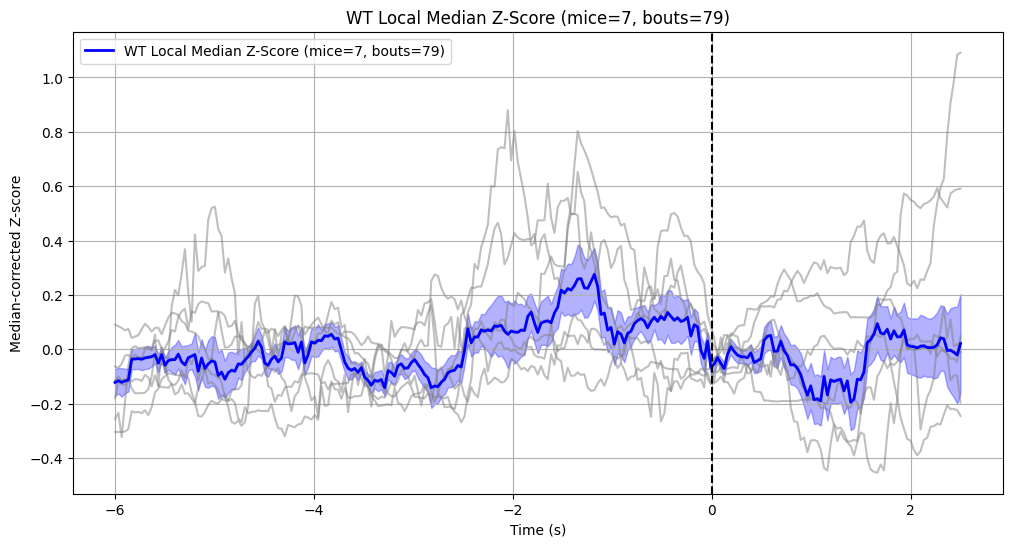

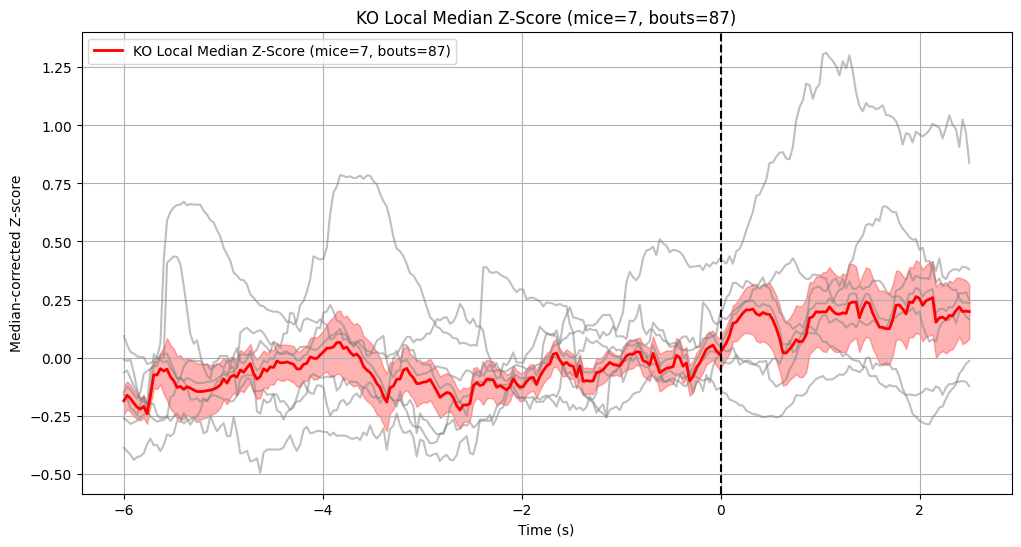

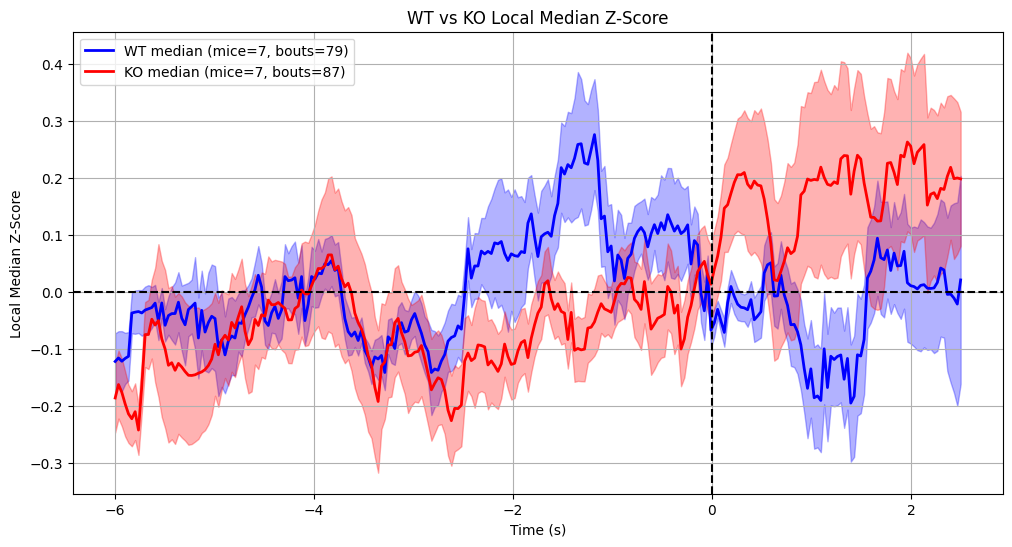


WT vs KO (Median) bin stats
Bin	TimeRange	P_uncorrected	P_corrected	Sig(FDR)
0	-6.00--5.73s	0.272	0.636	False
1	-5.70--5.43s	0.941	0.976	False
2	-5.40--5.13s	0.873	0.976	False
3	-5.10--4.83s	0.798	0.975	False
4	-4.80--4.53s	0.991	0.991	False
5	-4.49--4.23s	0.924	0.976	False
6	-4.19--3.93s	0.58	0.854	False
7	-3.89--3.62s	0.576	0.854	False
8	-3.59--3.32s	0.504	0.83	False
9	-3.29--3.02s	0.801	0.975	False
10	-2.99--2.72s	0.408	0.762	False
11	-2.69--2.42s	0.345	0.69	False
12	-2.39--2.12s	0.126	0.463	False
13	-2.08--1.82s	0.0861	0.463	False
14	-1.78--1.52s	0.119	0.463	False
15	-1.48--1.21s	0.0318	0.463	False
16	-1.18--0.91s	0.135	0.463	False
17	-0.88--0.61s	0.919	0.976	False
18	-0.58--0.31s	0.611	0.855	False
19	-0.28--0.01s	0.727	0.969	False
20	0.02-0.29s	0.0905	0.463	False
21	0.32-0.59s	0.225	0.572	False
22	0.63-0.89s	0.202	0.566	False
23	0.93-1.19s	0.07	0.463	False
24	1.23-1.50s	0.0572	0.463	False
25	1.53-1.80s	0.149	0.463	False
26	1.83-2.10s	0.31	0.668	False
27	2.13-2.40s	0.482	0.83	Fals

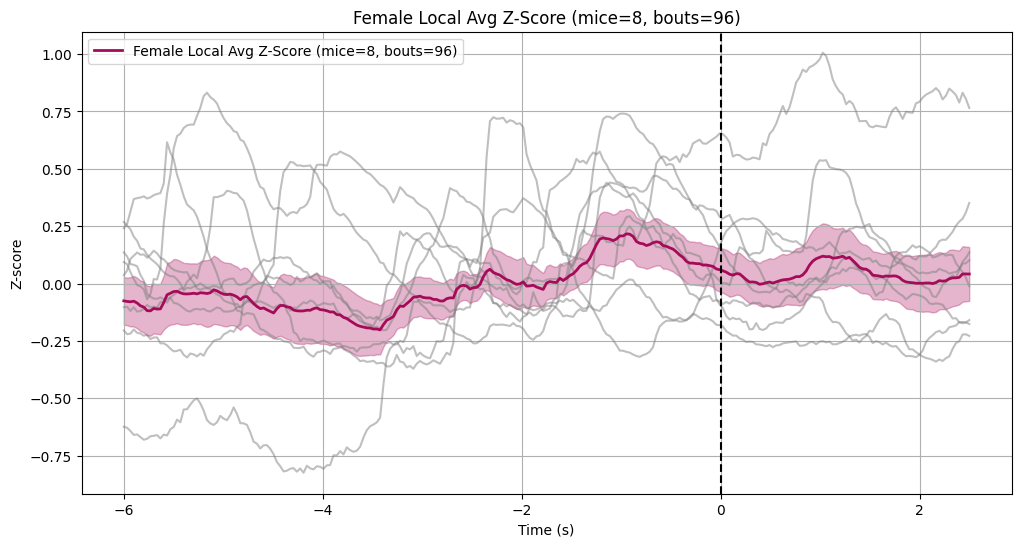

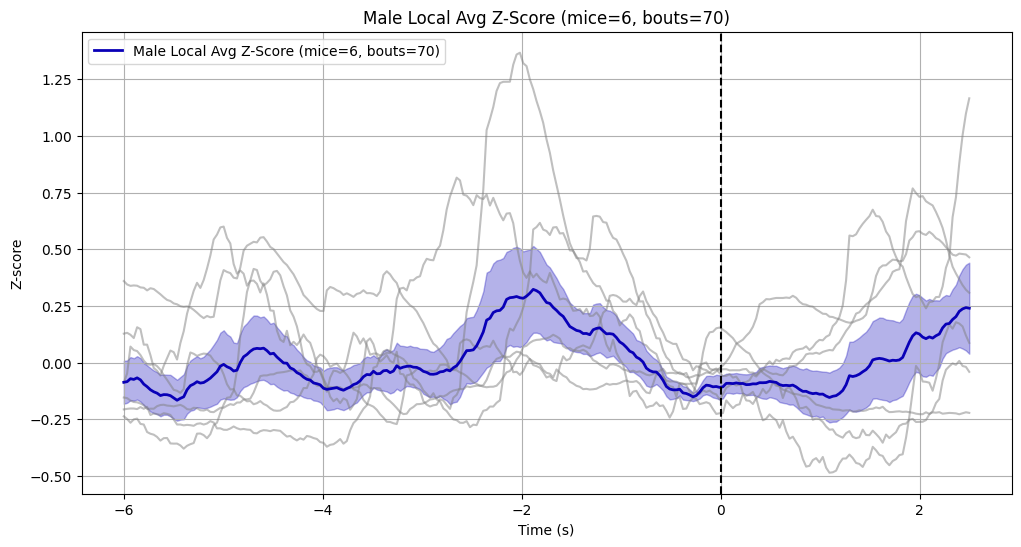

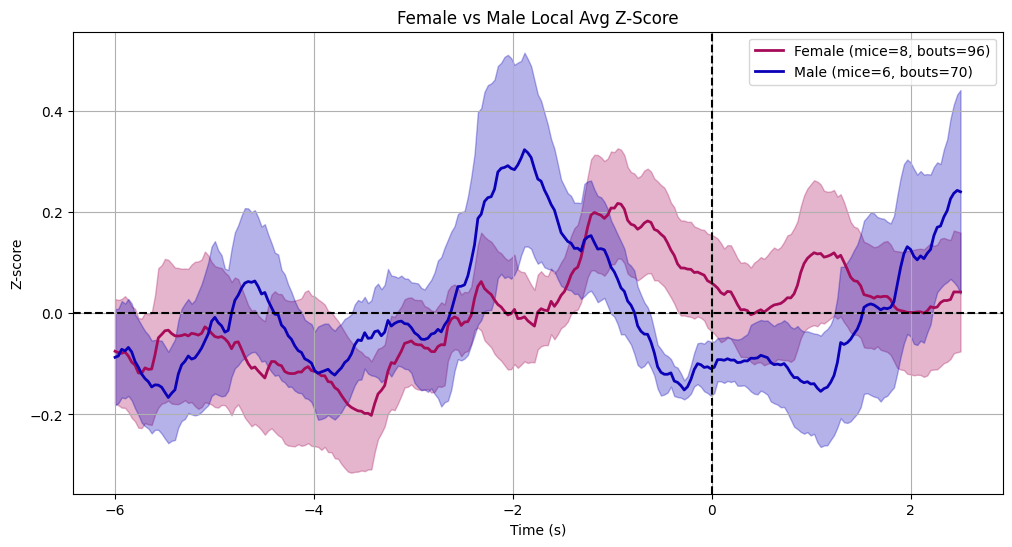


Female vs Male (Average) bin stats
Bin	TimeRange	P_uncorrected	P_corrected	Sig(FDR)
0	-6.00--5.73s	0.984	0.984	False
1	-5.70--5.43s	0.606	0.959	False
2	-5.40--5.13s	0.751	0.96	False
3	-5.10--4.83s	0.926	0.96	False
4	-4.80--4.53s	0.458	0.915	False
5	-4.49--4.23s	0.585	0.959	False
6	-4.19--3.93s	0.911	0.96	False
7	-3.89--3.62s	0.777	0.96	False
8	-3.59--3.32s	0.32	0.915	False
9	-3.29--3.02s	0.617	0.959	False
10	-2.99--2.72s	0.875	0.96	False
11	-2.69--2.42s	0.738	0.96	False
12	-2.39--2.12s	0.446	0.915	False
13	-2.08--1.82s	0.208	0.887	False
14	-1.78--1.52s	0.204	0.887	False
15	-1.48--1.21s	0.816	0.96	False
16	-1.18--0.91s	0.497	0.927	False
17	-0.88--0.61s	0.14	0.887	False
18	-0.58--0.31s	0.0345	0.887	False
19	-0.28--0.01s	0.0694	0.887	False
20	0.02-0.29s	0.222	0.887	False
21	0.32-0.59s	0.437	0.915	False
22	0.63-0.89s	0.336	0.915	False
23	0.93-1.19s	0.159	0.887	False
24	1.23-1.50s	0.45	0.915	False
25	1.53-1.80s	0.915	0.96	False
26	1.83-2.10s	0.672	0.96	False
27	2.13-2.40s	0.445	0.915	False

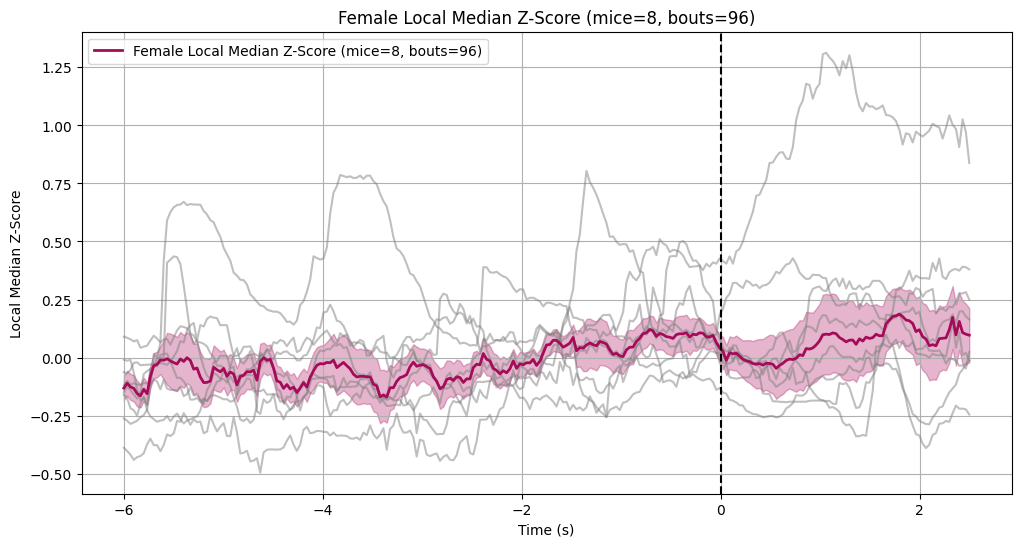

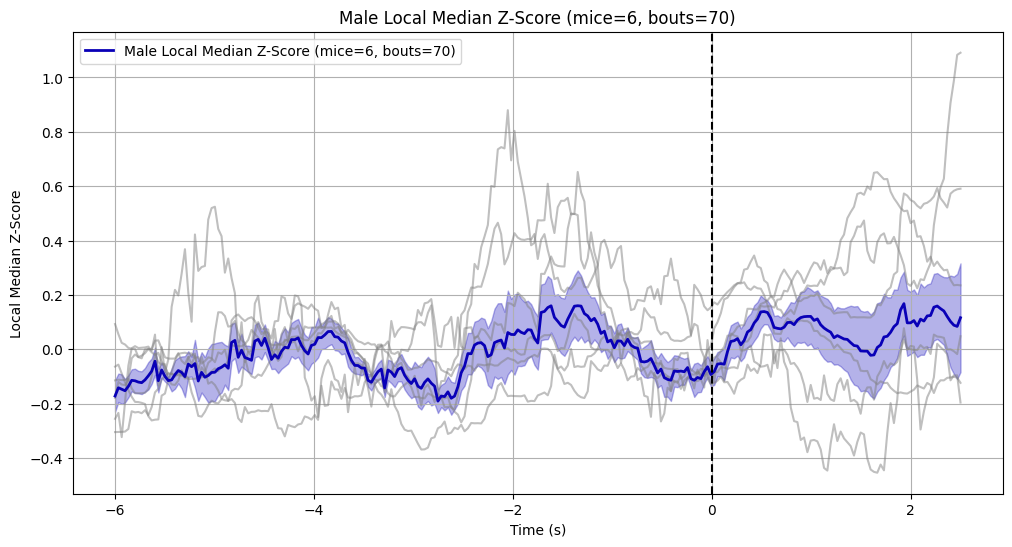

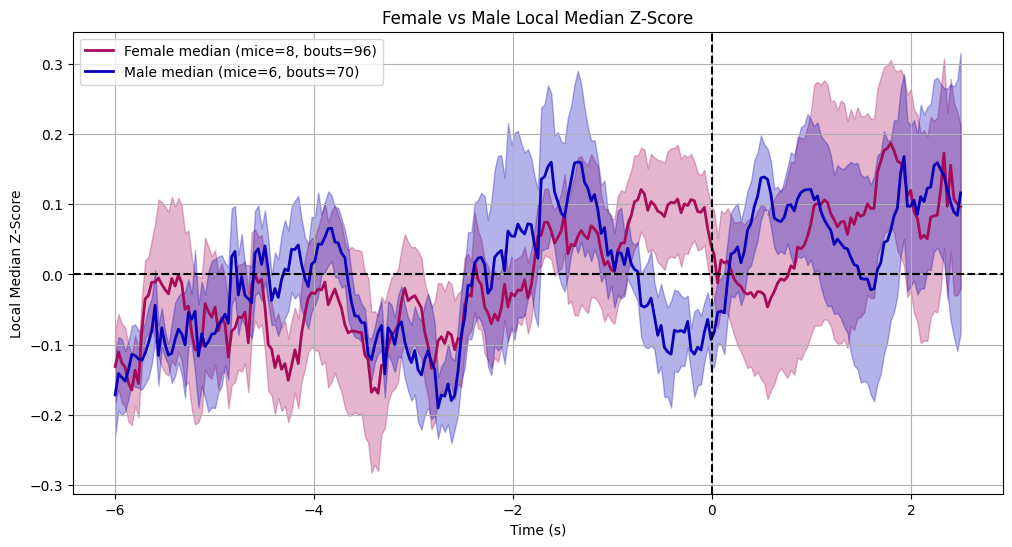


Female vs Male (Median) bin stats
Bin	TimeRange	P_uncorrected	P_corrected	Sig(FDR)
0	-6.00--5.73s	0.712	0.913	False
1	-5.70--5.43s	0.44	0.913	False
2	-5.40--5.13s	0.803	0.913	False
3	-5.10--4.83s	0.78	0.913	False
4	-4.80--4.53s	0.475	0.913	False
5	-4.49--4.23s	0.307	0.913	False
6	-4.19--3.93s	0.881	0.913	False
7	-3.89--3.62s	0.875	0.913	False
8	-3.59--3.32s	0.682	0.913	False
9	-3.29--3.02s	0.744	0.913	False
10	-2.99--2.72s	0.874	0.913	False
11	-2.69--2.42s	0.738	0.913	False
12	-2.39--2.12s	0.409	0.913	False
13	-2.08--1.82s	0.259	0.913	False
14	-1.78--1.52s	0.302	0.913	False
15	-1.48--1.21s	0.458	0.913	False
16	-1.18--0.91s	0.676	0.913	False
17	-0.88--0.61s	0.225	0.913	False
18	-0.58--0.31s	0.125	0.913	False
19	-0.28--0.01s	0.0574	0.913	False
20	0.02-0.29s	0.763	0.913	False
21	0.32-0.59s	0.76	0.913	False
22	0.63-0.89s	0.796	0.913	False
23	0.93-1.19s	0.457	0.913	False
24	1.23-1.50s	0.622	0.913	False
25	1.53-1.80s	0.502	0.913	False
26	1.83-2.10s	0.975	0.975	False
27	2.13-2.40s	0.859	0.91

In [ ]:
if __name__ == "__main__":

    # 1) Load once
    exps = load_experiments(CFG["data_folder"])

    # 2) Preprocess once
    for exp in exps:
        exp.smooth_grooming_bouts_generator(threshold=CFG["smooth_threshold"])

    # 3) Build groups once
    groups_geno = group_by_genotype(exps)   # {"WT":[...], "KO":[...]}
    groups_sex  = group_by_sex(exps)        # {"Female":[...], "Male":[...]}

    # 4) Run computations (no plotting here)
    res_geno_avg    = run_pipeline_for_groups(groups_geno, CFG, mode="avg")
    res_geno_median = run_pipeline_for_groups(groups_geno, CFG, mode="median")

    res_sex_avg     = run_pipeline_for_groups(groups_sex,  CFG, mode="avg")
    res_sex_median  = run_pipeline_for_groups(groups_sex,  CFG, mode="median")

    # =========================
    # PLOTTING & STATS OUTPUT (end only)
    # =========================
    common_t = res_geno_avg["common_t"]

    # ---- WT vs KO (Average) ----
    for label in ["WT", "KO"]:
        g = res_geno_avg["per_group"][label]

        mouse_plot, avg_plot, shift = apply_plot_centering(
            label, common_t, g["local"], g["group_avg"], CFG
        )
        if shift != 0:
            print(f"{label}: plot centering shift applied = {shift:.3f}")

        plot_traces(
            common_t,
            mouse_plot,
            avg_plot,
            g["group_sem"],  # SEM doesn't change when adding a constant
            title=f"{label} Local Avg Z-Score (mice={g['n_mice']}, bouts={g['n_bouts']})",
            color=CFG["colors"].get(label, "black"),
            figsize=CFG["figsize"],
            show_ind=CFG["show_individuals"],
            ylabel="Z-score",
        )

    # ---- Combined WT vs KO (Average) plot ONCE ----
    g_wt = res_geno_avg["per_group"]["WT"]
    g_ko = res_geno_avg["per_group"]["KO"]

    # Apply plot-only centering the same way as individual plots
    _, wt_avg_plot, wt_shift = apply_plot_centering("WT", common_t, g_wt["local"], g_wt["group_avg"], CFG)
    _, ko_avg_plot, ko_shift = apply_plot_centering("KO", common_t, g_ko["local"], g_ko["group_avg"], CFG)

    if wt_shift != 0:
        print(f"WT combined plot shift applied = {wt_shift:.3f}")
    if ko_shift != 0:
        print(f"KO combined plot shift applied = {ko_shift:.3f}")

    plot_combined(
        common_t,
        {
            f"WT (mice={g_wt['n_mice']}, bouts={g_wt['n_bouts']})":
                (wt_avg_plot, g_wt["group_sem"], CFG["colors"]["WT"]),
            f"KO (mice={g_ko['n_mice']}, bouts={g_ko['n_bouts']})":
                (ko_avg_plot, g_ko["group_sem"], CFG["colors"]["KO"]),
        },
        figsize=CFG["figsize"],
        ylabel="Z-score (GCaMP8s)",
        title="WT vs KO Local Avg Z-Score",
    )

    # Post-hoc stats print (Average)
    st = res_geno_avg["stats"].get(("WT", "KO"))
    if st is None:
        print("WT vs KO (Average): stats skipped (missing/empty group).")
    else:
        print("\nWT vs KO (Average) bin stats")
        print("Bin\tTimeRange\tP_uncorrected\tP_corrected\tSig(FDR)")
        for i, (start, end) in enumerate(st["bin_indices"]):
            tr = f"{common_t[start]:.2f}-{common_t[end-1]:.2f}s"
            p_unc = st["p_vals"][i]
            p_cor = st["p_corr"][i]
            sig = st["sig_mask"][i]
            print(f"{i}\t{tr}\t{p_unc:.3g}\t{p_cor:.3g}\t{bool(sig)}")

    # ---- WT vs KO (Median) ----
    common_t = res_geno_median["common_t"]
    
    for label in ["WT", "KO"]:
        g = res_geno_median["per_group"][label]
        plot_traces(
            common_t,
            g["local"],
            g["group_avg"],
            g["group_sem"],
            title=f"{label} Local Median Z-Score (mice={g['n_mice']}, bouts={g['n_bouts']})",
            color=CFG["colors"].get(label, "black"),
            figsize=CFG["figsize"],
            show_ind=CFG["show_individuals"],
            ylabel="Median-corrected Z-score",
        )

    plot_combined(
        common_t,
        {
            f"WT median (mice={res_geno_median['per_group']['WT']['n_mice']}, bouts={res_geno_median['per_group']['WT']['n_bouts']})":
                (res_geno_median["per_group"]["WT"]["group_avg"], res_geno_median["per_group"]["WT"]["group_sem"], CFG["colors"]["WT"]),
            f"KO median (mice={res_geno_median['per_group']['KO']['n_mice']}, bouts={res_geno_median['per_group']['KO']['n_bouts']})":
                (res_geno_median["per_group"]["KO"]["group_avg"], res_geno_median["per_group"]["KO"]["group_sem"], CFG["colors"]["KO"]),
        },
        figsize=CFG["figsize"],
        ylabel="Local Median Z-Score",
        title="WT vs KO Local Median Z-Score",
    )

    st = res_geno_median["stats"].get(("WT", "KO"))
    if st is None:
        print("WT vs KO (Median): stats skipped (missing/empty group).")
    else:
        print("\nWT vs KO (Median) bin stats")
        print("Bin\tTimeRange\tP_uncorrected\tP_corrected\tSig(FDR)")
        for i, (start, end) in enumerate(st["bin_indices"]):
            tr = f"{common_t[start]:.2f}-{common_t[end-1]:.2f}s"
            p_unc = st["p_vals"][i]
            p_cor = st["p_corr"][i]
            sig = st["sig_mask"][i]
            print(f"{i}\t{tr}\t{p_unc:.3g}\t{p_cor:.3g}\t{bool(sig)}")

    # ---- Female vs Male (Average + Median) ----
    common_t_sex = res_sex_avg["common_t"]

    for label in ["Female", "Male"]:
        g = res_sex_avg["per_group"][label]
        plot_traces(
            common_t_sex,
            g["local"],
            g["group_avg"],
            g["group_sem"],
            title=f"{label} Local Avg Z-Score (mice={g['n_mice']}, bouts={g['n_bouts']})",
            color=CFG["colors"].get(label, "black"),
            figsize=CFG["figsize"],
            show_ind=CFG["show_individuals"],
            ylabel="Z-score",
        )

    plot_combined(
        common_t_sex,
        {
            f"Female (mice={res_sex_avg['per_group']['Female']['n_mice']}, bouts={res_sex_avg['per_group']['Female']['n_bouts']})":
                (res_sex_avg["per_group"]["Female"]["group_avg"], res_sex_avg["per_group"]["Female"]["group_sem"], CFG["colors"]["Female"]),
            f"Male (mice={res_sex_avg['per_group']['Male']['n_mice']}, bouts={res_sex_avg['per_group']['Male']['n_bouts']})":
                (res_sex_avg["per_group"]["Male"]["group_avg"], res_sex_avg["per_group"]["Male"]["group_sem"], CFG["colors"]["Male"]),
        },
        figsize=CFG["figsize"],
        ylabel="Z-score",
        title="Female vs Male Local Avg Z-Score",
    )

    st = res_sex_avg["stats"].get(("Female", "Male"))
    if st is None:
        print("Female vs Male (Average): stats skipped (missing/empty group).")
    else:
        print("\nFemale vs Male (Average) bin stats")
        print("Bin\tTimeRange\tP_uncorrected\tP_corrected\tSig(FDR)")
        for i, (start, end) in enumerate(st["bin_indices"]):
            tr = f"{common_t_sex[start]:.2f}-{common_t_sex[end-1]:.2f}s"
            p_unc = st["p_vals"][i]
            p_cor = st["p_corr"][i]
            sig = st["sig_mask"][i]
            print(f"{i}\t{tr}\t{p_unc:.3g}\t{p_cor:.3g}\t{bool(sig)}")

    for label in ["Female", "Male"]:
        g = res_sex_median["per_group"][label]
        plot_traces(
            common_t_sex,
            g["local"],
            g["group_avg"],
            g["group_sem"],
            title=f"{label} Local Median Z-Score (mice={g['n_mice']}, bouts={g['n_bouts']})",
            color=CFG["colors"].get(label, "black"),
            figsize=CFG["figsize"],
            show_ind=CFG["show_individuals"],
            ylabel="Local Median Z-Score",
        )

    plot_combined(
        common_t_sex,
        {
            f"Female median (mice={res_sex_median['per_group']['Female']['n_mice']}, bouts={res_sex_median['per_group']['Female']['n_bouts']})":
                (res_sex_median["per_group"]["Female"]["group_avg"], res_sex_median["per_group"]["Female"]["group_sem"], CFG["colors"]["Female"]),
            f"Male median (mice={res_sex_median['per_group']['Male']['n_mice']}, bouts={res_sex_median['per_group']['Male']['n_bouts']})":
                (res_sex_median["per_group"]["Male"]["group_avg"], res_sex_median["per_group"]["Male"]["group_sem"], CFG["colors"]["Male"]),
        },
        figsize=CFG["figsize"],
        ylabel="Local Median Z-Score",
        title="Female vs Male Local Median Z-Score",
    )

    st = res_sex_median["stats"].get(("Female", "Male"))
    if st is None:
        print("Female vs Male (Median): stats skipped (missing/empty group).")
    else:
        print("\nFemale vs Male (Median) bin stats")
        print("Bin\tTimeRange\tP_uncorrected\tP_corrected\tSig(FDR)")
        for i, (start, end) in enumerate(st["bin_indices"]):
            tr = f"{common_t_sex[start]:.2f}-{common_t_sex[end-1]:.2f}s"
            p_unc = st["p_vals"][i]
            p_cor = st["p_corr"][i]
            sig = st["sig_mask"][i]
            print(f"{i}\t{tr}\t{p_unc:.3g}\t{p_cor:.3g}\t{bool(sig)}")